In [9]:
import tensorflow as tf
import keras
from keras import layers, models
import numpy as np
import os

# 1. First analyze class distribution
def print_class_distribution(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    
    print("Class distribution:")
    for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{class_name}: {count} images")
    return class_counts

class_counts = print_class_distribution("../data/faces3")

# 2. Create balanced dataset with oversampling
def create_balanced_dataset(data_dir, target_size=(224, 224), batch_size=32):
    # Calculate class weights
    total = sum(class_counts.values())
    max_samples = max(class_counts.values())
    class_weights = {class_name: max_samples/count 
                    for class_name, count in class_counts.items()}
    
    # Create dataset with augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8,1.2],
        zoom_range=0.2,
        fill_mode='nearest'
    )
    
    train_ds = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training',
        shuffle=True
    )
    
    val_ds = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation',
        shuffle=True
    )
    
    return train_ds, val_ds, class_weights

# 3. Create improved model architecture
def create_face_recognition_model(num_classes):
    # Use ResNet50V2 backbone
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    
    # Unfreeze layers gradually
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    
    model = models.Sequential([
        layers.Input((224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# 4. Training with proper strategy
train_ds, val_ds, class_weights = create_balanced_dataset("../data/faces3")
model = create_face_recognition_model(len(class_counts))

# Learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=1000
)

# Compile with weighted categorical crossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_face_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    )
]

# Train with class weights
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    class_weight=class_weights
)

# Function for inference with augmentation
def predict_with_augmentation(model, image, num_augments=5):
    """Predict with test-time augmentation."""
    predictions = []
    
    # Original image
    predictions.append(model.predict(tf.expand_dims(image, 0)))
    
    # Data augmentation for inference
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(0.1)
    ])
    
    # Augmented versions
    for _ in range(num_augments - 1):
        aug_image = data_augmentation(tf.expand_dims(image, 0))[0]
        predictions.append(model.predict(tf.expand_dims(aug_image, 0)))
    
    return np.mean(predictions, axis=0)

Class distribution:
matthias: 73 images
senne: 58 images
michiel: 58 images
akif: 57 images
youssef: 50 images
lasse: 41 images
konrad: 41 images
raul: 41 images
seppe: 35 images
bart: 34 images
alper: 32 images
nelli: 31 images
florian: 30 images
daiane: 30 images
Found 493 images belonging to 14 classes.
Found 118 images belonging to 14 classes.


ValueError: Expected `class_weight` to be a dict with keys from 0 to one less than the number of classes, found {'matthias': 1.0, 'lasse': 1.7804878048780488, 'akif': 1.280701754385965, 'bart': 2.1470588235294117, 'florian': 2.433333333333333, 'daiane': 2.433333333333333, 'konrad': 1.7804878048780488, 'senne': 1.2586206896551724, 'michiel': 1.2586206896551724, 'seppe': 2.085714285714286, 'youssef': 1.46, 'raul': 1.7804878048780488, 'alper': 2.28125, 'nelli': 2.3548387096774195}

In [ ]:
model.save('final_face_model.keras')

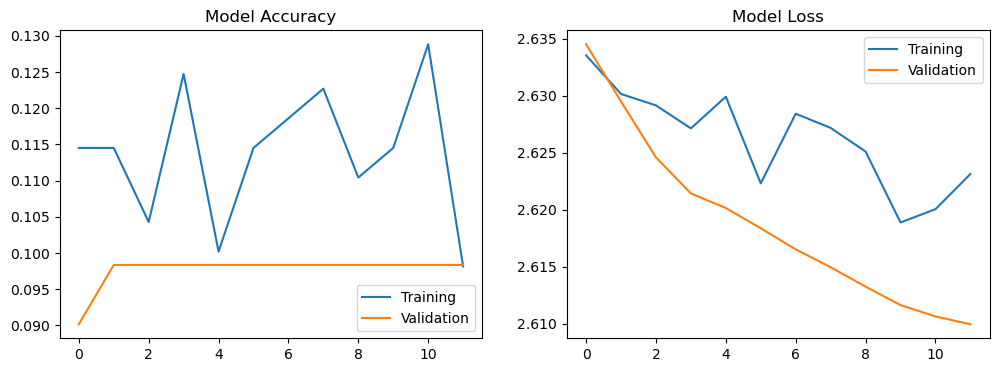

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.legend()
    
    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
train_ds

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import os

model = tf.keras.models.load_model('final_face_model.keras')

def predict_face(model, image_path, class_names):
    """
    Predict face from image path and show results
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)
    
    # Get predictions
    predictions = model.predict(img)
    
    # Get top 3 predictions
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    
    # Plot image with predictions
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.axis('off')
    plt.title('Test Image')
    
    plt.subplot(1, 2, 2)
    colors = ['gold', 'silver', 'brown']
    y_pos = np.arange(3)
    
    # Plot top 3 predictions as bar chart
    confidences = [predictions[0][i] * 100 for i in top_3_idx]
    labels = [class_names[i] for i in top_3_idx]
    
    plt.barh(y_pos, confidences, color=colors)
    plt.yticks(y_pos, labels)
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nDetailed predictions:")
    for i, idx in enumerate(top_3_idx):
        print(f"{i+1}. {class_names[idx]}: {predictions[0][idx]*100:.2f}%")

# Example usage:
data_dir = "../data/faces3"
class_names = sorted([folder for folder in os.listdir(data_dir) 
                     if os.path.isdir(os.path.join(data_dir, folder))])

print("Found classes:", class_names)

# Update the predict call with these class names
test_image_path = "../data/faces3_test/0037_face_0.jpg"
predict_face(model, test_image_path, class_names)

# For multiple images
test_folder = "../data/faces3_test"
for image_file in os.listdir(test_folder):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(test_folder, image_file)
        print(f"\nTesting image: {image_file}")
        predict_face(model, image_path, class_names)
        
        

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']